# Cargar dataset y librerías

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar el dataset
# (Reemplaza 'movies_dataset.csv' con la ruta correcta del archivo)
df = pd.read_csv("/content/TMDB_movie_dataset_v11.csv")

# Mostrar información general del dataset
print(df.info())

# Visualizar las primeras filas
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161557 entries, 0 to 1161556
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1161557 non-null  int64  
 1   title                 1161544 non-null  object 
 2   vote_average          1161557 non-null  float64
 3   vote_count            1161557 non-null  int64  
 4   status                1161557 non-null  object 
 5   release_date          963834 non-null   object 
 6   revenue               1161557 non-null  int64  
 7   runtime               1161557 non-null  int64  
 8   adult                 1161557 non-null  bool   
 9   backdrop_path         306287 non-null   object 
 10  budget                1161557 non-null  int64  
 11  homepage              122521 non-null   object 
 12  imdb_id               608670 non-null   object 
 13  original_language     1161557 non-null  object 
 14  original_title        1161544 non-

# Preprocesamiento de datos

In [3]:
# Seleccionar las columnas relevantes para el análisis
selected_columns = ['vote_average', 'revenue', 'popularity', 'genres', 'runtime']
df_selected = df[selected_columns].copy()

# Eliminar filas con valores nulos en las columnas clave
df_selected.dropna(subset=['vote_average', 'revenue', 'popularity', 'runtime', 'genres'], inplace=True)

# Convertir géneros en variables categóricas (One-Hot Encoding)
# Suponemos que 'genres' es una lista de géneros en formato string y tomamos solo el primer género por simplicidad
df_selected['genres'] = df_selected['genres'].apply(lambda x: x.split(",")[0] if isinstance(x, str) else "Unknown")

# Codificar las variables categóricas (géneros) con One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
genres_encoded = encoder.fit_transform(df_selected[['genres']])
genres_df = pd.DataFrame(genres_encoded, columns=encoder.get_feature_names_out(['genres']))

# Unir los datos transformados al dataframe original
df_final = pd.concat([df_selected.drop(columns=['genres']), genres_df], axis=1)

# Normalizar las variables numéricas (Revenue, Popularity, Runtime)
scaler = StandardScaler()
df_final[['revenue', 'popularity', 'runtime']] = scaler.fit_transform(df_final[['revenue', 'popularity', 'runtime']])

# Mostrar la estructura final de los datos
print(df_final.info())
print(df_final.head())


<class 'pandas.core.frame.DataFrame'>
Index: 940770 entries, 0 to 691331
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   vote_average            691332 non-null  float64
 1   revenue                 691332 non-null  float64
 2   popularity              691332 non-null  float64
 3   runtime                 691332 non-null  float64
 4   genres_Adventure        691332 non-null  float64
 5   genres_Animation        691332 non-null  float64
 6   genres_Comedy           691332 non-null  float64
 7   genres_Crime            691332 non-null  float64
 8   genres_Documentary      691332 non-null  float64
 9   genres_Drama            691332 non-null  float64
 10  genres_Family           691332 non-null  float64
 11  genres_Fantasy          691332 non-null  float64
 12  genres_History          691332 non-null  float64
 13  genres_Horror           691332 non-null  float64
 14  genres_Music            6

# Exploración de datos

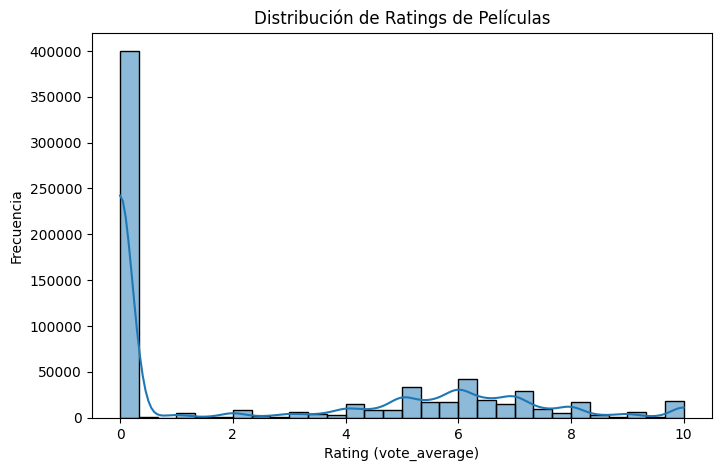

In [5]:
# Histograma del rating
plt.figure(figsize=(8,5))
sns.histplot(df_final['vote_average'], bins=30, kde=True)
plt.title("Distribución de Ratings de Películas")
plt.xlabel("Rating (vote_average)")
plt.ylabel("Frecuencia")
plt.show()



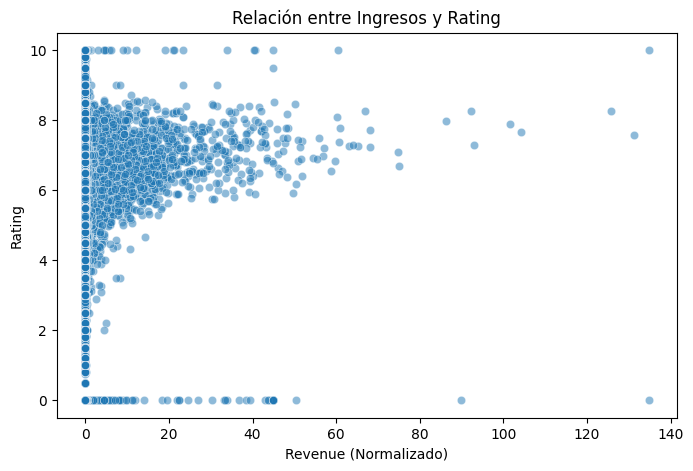

In [6]:
# Relación entre revenue y vote_average
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_final['revenue'], y=df_final['vote_average'], alpha=0.5)
plt.title("Relación entre Ingresos y Rating")
plt.xlabel("Revenue (Normalizado)")
plt.ylabel("Rating")
plt.show()


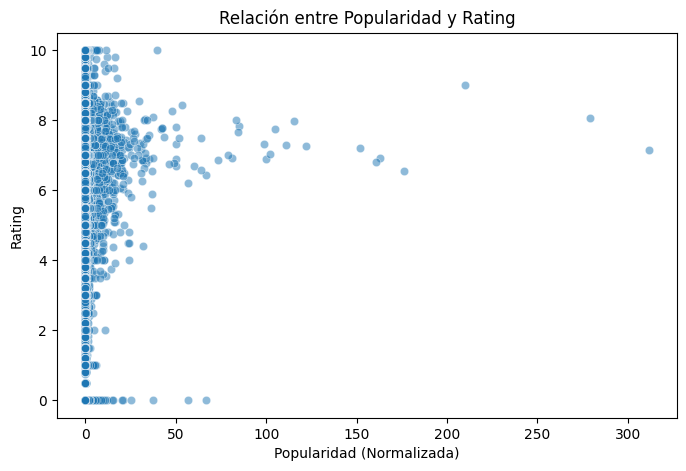

In [7]:
# Relación entre popularidad y vote_average
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_final['popularity'], y=df_final['vote_average'], alpha=0.5)
plt.title("Relación entre Popularidad y Rating")
plt.xlabel("Popularidad (Normalizada)")
plt.ylabel("Rating")
plt.show()


# Construcción del Modelo de Predicción

In [10]:
# Remove rows with NaN in 'vote_average' before splitting
df_final.dropna(subset=['vote_average'], inplace=True)

# Definir variables independientes (X) y dependiente (y)
X = df_final.drop(columns=['vote_average'])
y = df_final['vote_average']

# Separar datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"🔹 MAE: {mae:.3f}")
print(f"🔹 MSE: {mse:.3f}")
print(f"🔹 RMSE: {rmse:.3f}")
print(f"🔹 R²: {r2:.3f}")



🔹 MAE: 1.476
🔹 MSE: 5.590
🔹 RMSE: 2.364
🔹 R²: 0.464


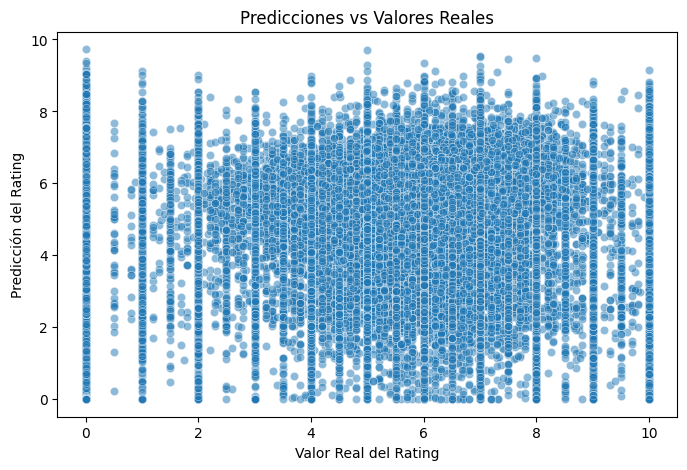

In [11]:
# Visualización de predicciones vs valores reales
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Valor Real del Rating")
plt.ylabel("Predicción del Rating")
plt.title("Predicciones vs Valores Reales")
plt.show()